### NOW EXPERIMENTING:
Pinet: 
* try pure training dataset, should be same to normal train
* remove noise (seems noise effect performance a lots), ramp_up_delay=20, ramp_up_T=50, w = 100/T,  dropout = 0.5, adam lr = 0.0025
* change core model

### Done:
* noise and rotation cause huge performance decrease.....
* randomize in first batch otherwise loss seems a bit strange.
* add some random noice
* custom data generate to update test temperal mask every n epoch
* change unsupervise loss weight on the fly
* used full model (without dropout) for validation and prediction
* close augmentation: noise, rotation, no temperal predict, no temperal loss
* ramp-up function is also important as early psuedo label is very wrong, reduced temperal loss in early stage, otherwise network will learn wrong pattern from early stage psuedo label
* train on train then test order, insure frist part of training has all label, which won't confuse network, solution: use a ration to adjust how much label vs unlabel loss will go into total loss (unlabled size / batch size) * w
* loss is toooooooo high without any reason: its cause by test data, when update weight with test data which don't have label, it cause network confuse because those update don't have gradient, (are based on other's graident)...
* sample data(train + test) from db, split train data into train val data
* apply test data mask if its none (no temperal mask)
* basic augmentation twice for pinet
* custom pi net loss function
* move prediction into here as it used custom function

### work: 
* image data augmentation, flip, crop,
* resnet with high dropout, (as resnet so easy overfitting, and not enough data)
* 2d spatial dropout
* dice loss, faster converge, but doesn't help improve score....

### not work:
* deeper, shellower
* Clahe
* pure dice loss, it will give binary solution, rather than probability
* dropout=0.6, overfitting, Val=0.8, LB=0.77

### idea:
* augmentation: rotation, affine transform, Elastic deformations
* reduce dropout, as always under fitting
* smaller batch size
* CRF
* inception block


In [1]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
from skimage import exposure
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage import transform
from skimage import util
from tqdm import tqdm_notebook
import skimage as sk
import gc
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import keras
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Concatenate, SpatialDropout2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers.merge import add
from keras import regularizers
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.activations import softmax
from keras.backend import tensorflow_backend, common
from keras.callbacks import LambdaCallback, Callback
import tensorflow as tf

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
path_train = '../data/train/'
path_test = '../data/test/'
train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = pd.read_csv("../data/train.csv", index_col="id")

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def insert_data(data, db, collection, check_id='id', host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    duplicate_result = db[collection].find(
       {check_id: data[check_id]})
    
    print('duplicate count' + str(duplicate_result.count()))
    if duplicate_result.count() == 0:
        db[collection].insert_one(data)

def set_data(db, collection, search, set_query, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].update(
        search,
        { '$set': set_query }
    )
        
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def sample_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, num_sample=1000):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].aggregate([{ "$sample": { "size": num_sample }}])

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

# Put all dataset into DF frist, hold in memory

In [4]:
img_size_ori = 101
img_size_target = 128

def read_resize_img(x, scale,mask=False):
    img_byte = io.BytesIO(base64.b64decode(x))
    img_np = np.array(imread(img_byte, as_gray=True))/scale
    img_np = resize(img_np,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    if mask:
        img_np[img_np>0] = 1
    return img_np

train_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$ne":None}}]})
# test_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})
test_df = sample_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]}, num_sample=10)

# train_df = train_df.loc[:20]

train_df['img'] = train_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
train_df['img_mask'] = train_df['img_mask_base64'].apply(lambda x: read_resize_img(x, 65535.0, mask=True))
train_df['img_temperal_mask'] = train_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img'] = test_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
test_df['img_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img_temperal_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))

train_df = train_df.drop('img_base64', axis=1)
train_df = train_df.drop('img_mask_base64', axis=1)
train_df = train_df.drop('ASM', axis=1)
train_df = train_df.drop('contrast', axis=1)
train_df = train_df.drop('correlation', axis=1)
train_df = train_df.drop('dissimilarity', axis=1)
train_df = train_df.drop('energy', axis=1)
train_df = train_df.drop('entropy', axis=1)
train_df = train_df.drop('homogeneity', axis=1)
train_df = train_df.drop('coverage', axis=1)
train_df = train_df.drop('coverage_class', axis=1)
test_df = test_df.drop('img_base64', axis=1)
# test_df = test_df.drop('img_mask_base64', axis=1)
# test_df = test_df.drop('ASM', axis=1)
# test_df = test_df.drop('contrast', axis=1)
# test_df = test_df.drop('correlation', axis=1)
# test_df = test_df.drop('dissimilarity', axis=1)
# test_df = test_df.drop('energy', axis=1)
# test_df = test_df.drop('entropy', axis=1)
# test_df = test_df.drop('homogeneity', axis=1)
# test_df = test_df.drop('coverage', axis=1)
# test_df = test_df.drop('coverage_class', axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.1)
# train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)
train_test_df = train_df.copy()

In [5]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_test_df.shape)

(3600, 7)
(400, 7)
(10, 17)
(3600, 7)


In [6]:
# train_test_df.head(-1)

# Data Preprcessing function: sample, augment, to np_array

In [7]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.0005
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.01
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      scale = 0.05
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss * scale
      return noisy
   elif noise_typ == 'None':
      return image

def _img_augmentation(_df, if_augment=True):
    def random_crop_resize(x, crop, flip, degree, noise_type='None'):
        # return x if all pixel is -1
        if np.mean(x) == -1:
            return x
        
        x = np.fliplr(x) if flip else x
#         x = np.squeeze(noisy(noise_type, np.expand_dims(x, axis=3)))
#         x = sk.transform.rotate(x, degree)
        x = x[crop[0]:-crop[1],crop[2]:-crop[3]]
        x = resize(x,(img_size_target,img_size_target), mode='constant', preserve_range=True)
        return x

    def img_augment(df):
        augment_df = pd.DataFrame()
        for index, row in df.iterrows():
            # np.random.seed(0)
            crop = np.random.randint(low=1, high=20, size=4) if if_augment else np.array([0, 1, 0, 1])
            flip = np.random.choice([True, False]) if if_augment else False
            degree = np.random.uniform(-10, 10) if if_augment else 0
            noise_type = np.random.choice(['gauss', 'poisson', 's&p', 'speckle', 'None']) if if_augment else 'None'
            
            aug_img = random_crop_resize(row['img'], crop, flip, degree, noise_type)
            aug_img_mask = random_crop_resize(row['img_mask'], crop, flip, degree)
            aug_img_temperal_mask = random_crop_resize(row['img_temperal_mask'], crop, flip, degree)

            
            augment_df = augment_df.append(
                {
                    'depth': row['depth'],
                    'img_id': row['img_id']+'_augment',
                    'aug_img': aug_img,
                    'aug_img_mask': aug_img_mask,
                    'aug_img_temperal_mask': aug_img_temperal_mask,
                }, ignore_index=True
            )
        return augment_df
    
    _augment_df = img_augment(_df)
    
    return _augment_df

def _convert_to_np_array(_augment_df):
    X_np = np.expand_dims(np.stack((np.asarray(_augment_df['aug_img'].values.tolist()))),axis=3)
    y_np = np.expand_dims(np.asarray(_augment_df['aug_img_mask'].values.tolist()),axis=3)
    y_temp_np = np.expand_dims(np.asarray(_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)
    y_np = np.concatenate((y_np,y_temp_np),axis=3)
    
    return X_np, y_np

def calculate_temperal_mask(epoch):
    global model_train, train_df, test_df, graph_train
    with graph_train.as_default():
        X_train = np.expand_dims(np.stack((np.asarray(train_df['img'].values.tolist()))),axis=3)
        predict_train = model_train.predict(X_train,batch_size=64, verbose=1)
        predict_train = np.squeeze(predict_train)
        
        X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
        predict_test = model_train.predict(X_test,batch_size=64, verbose=1)
        predict_test = np.squeeze(predict_test)
    
    idx = 0;
    alpha = 0.5
#     temperal_mask_ramp_up = 1/(1-(alpha**(epoch+1)))
    for index, row in tqdm_notebook(train_df.iterrows(),total=len(train_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_train[idx]; idx+=1;
        if(np.mean(img_temperal_mask) < 0):
            train_df.at[index,'img_temperal_mask'] = predict
        else:
            train_df.at[index,'img_temperal_mask'] = (img_temperal_mask*alpha + predict*(1-alpha))
            
    for index, row in tqdm_notebook(test_df.iterrows(),total=len(test_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_test[index]
        if(np.mean(img_temperal_mask) < 0):
            test_df.at[index,'img_temperal_mask'] = predict
        else:
            test_df.at[index,'img_temperal_mask'] = (img_temperal_mask*alpha + predict*(1-alpha))
    
    train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)

    return train_test_df

# plot some augmented image

In [8]:
# sample_train_df = train_df.sample(50)
# train_augment_df = _img_augmentation(sample_train_df)

# %%time
# sample_train_df, sample_val_df, sample_test_df = sample_df(train_df, val_df, test_df)
# train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)
# X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)

# test_augment_df.head(1)

In [9]:
# train_augment_df.head(10)

In [10]:
# base_idx = 0
# max_images = 16
# grid_width = 4
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
# row = 0; col = 0;
# for i, idx in enumerate(train_augment_df.index[base_idx:base_idx+int(max_images)]):
#     img = train_augment_df.loc[idx].aug_img
#     mask = train_augment_df.loc[idx].aug_img_mask
    
#     ax = axs[row, col];
#     ax.imshow(img, cmap="seismic")
# #     ax.imshow(img, cmap="gray")
#     ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
#     ax.set_yticklabels([]); ax.set_xticklabels([]);
    
#     if col >= grid_width:
#         col=0; row+=1;


# Custom loss function

In [11]:
from debug import _debug_func

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

# MSE between current and temporal outputs
def temperal_mse_loss(y_true, y_pred):

    def mse_loss(y_pred, y_temperal, temperal_size):
        # generate filter using y_temperal
        temperal_filter = tf.stop_gradient(tf.cast(tf.not_equal(y_temperal, -1), tf.float32))

        # filter out MSE if temperal = -1
        quad_diff = K.sum((temperal_filter*y_pred - temperal_filter*y_temperal) ** 2) / (temperal_size*128*128+1e-15)

        return quad_diff

    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])

    # count temperal size which has value (not -1)
    temperal_size=tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_temperal, [1,2,3]), -1), tf.float32)))

    quad_diff = tf.cond(temperal_size > 0, lambda: mse_loss(y_pred, y_temperal, temperal_size), lambda: 0.0)

    return quad_diff

def masked_crossentropy(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
#     y_mask = _debug_func((y_mask),"y_mask")

    # count mask size
    mask_size=tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32)))

    # generate mask filter as test doesn't have mask (-1)
    mask_filter = tf.stop_gradient(tf.cast(tf.not_equal(y_mask, -1), tf.float32))

    y_mask = y_mask*mask_filter
    y_pred = y_pred*mask_filter
    
    bce_loss_ = tf.cond(mask_size > 0, lambda: (K.sum(binary_crossentropy(y_mask, y_pred))/(mask_size*128*128+1e-15)), lambda: 0.0)    
    dice_loss_ = dice_loss(y_mask, y_pred)
    
    bce_dice_loss_ = bce_loss_ + dice_loss_

    return bce_dice_loss_

def mask_mean_iou(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)
    mask_mean_iou = mean_iou(mask_filter*y_mask, mask_filter*y_pred)
    return mask_mean_iou

def temperal_mean_iou(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)
    temperal_mean_iou = mean_iou(temperal_filter*(tf.cast(tf.greater(y_temperal,0.5), tf.float32)), temperal_filter*y_pred)
    return temperal_mean_iou

class Temperal_Callback(Callback):
    def __init__(self):
        self.ramp_up = 0
        self.T = 50
        self.w = 1.0 / self.T
        self.delay = 5
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch- self.delay < 0:
            self.ramp_up = 0
        elif epoch - self.delay < self.T:
            self.ramp_up = np.exp(-5*((1-((epoch-self.delay)/self.T)))**2)
        else:
            self.ramp_up = 1
        logger.info("epoch %s, ramp_up = %s" % (epoch, self.ramp_up))

    def temporal_loss(self, y_true, y_pred):
        sup_loss = masked_crossentropy(y_true, y_pred)
        unsup_loss = temperal_mse_loss(y_true, y_pred)

        batch_size = tf.stop_gradient(tf.to_float(tf.shape(y_pred)[0]))
        y_mask = tf.stop_gradient(tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1]))
        mask_size = tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32)))
        
        w = self.w * (1.0-(mask_size/batch_size)) * self.ramp_up
#         sup_loss = _debug_func((sup_loss),"sup_loss")
#         unsup_loss = _debug_func((unsup_loss),"unsup_loss")
        
        return sup_loss
#         return sup_loss + w * unsup_loss

# DataGenerator

In [12]:
class DataGenerator(keras.utils.Sequence):
    #class static variable
    global model_train
    _val_df = None
    _train_test_df = None
    _X_train = None
    _y_train = None
    _X_valid = None
    _y_valid = None
    
    'Generates data for Keras'
    def __init__(self, train_test_df, val_df, batch_size=32, shuffle=True, training=True, temperal_epoch=1):
        self.training = training
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.epoch = 0
        self.val_size = val_df.shape[0]
        self.train_test_size = train_test_df.shape[0]
        self.temperal_epoch = temperal_epoch
        
        print(f'val_size = {self.val_size}, \
              train_test_size = {self.train_test_size}, \
              ')
        
        'Initial static variable'
        if self.training:
            DataGenerator._val_df = val_df
            DataGenerator._train_test_df = train_test_df

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.training:
            print('train lenght')
            print(int(np.floor((self.train_test_size) / self.batch_size)))
            return int(np.floor((self.train_test_size) / self.batch_size))
        else:
            print('val lenght')
            print(int(np.floor(self.val_size / self.batch_size)))
            return int(np.floor(self.val_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        'index: indicate which batch in a epoch, (first, second or third batch)'
        # Generate indexes of the batch
        if self.training:            
            batch_train_df = DataGenerator._train_test_df.iloc[index*self.batch_size:(index+1)*self.batch_size]
            train_augment_df = _img_augmentation(batch_train_df)
            X_train_np, y_train_np = _convert_to_np_array(train_augment_df)
            
            return X_train_np, y_train_np
        else:
            batch_val_df = DataGenerator._val_df.iloc[index*self.batch_size:(index+1)*self.batch_size]
            val_augment_df = _img_augmentation(batch_val_df, if_augment=False)
            X_val_np, y_val_np = _convert_to_np_array(val_augment_df)
            
            del batch_val_df, val_augment_df
            
            return X_val_np, y_val_np

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        print(f', epoch={self.epoch}')
#         if self.epoch % self.temperal_epoch == 0 and self.training and self.epoch >= 5:
#             new_train_test_df = calculate_temperal_mask(self.epoch)
#             DataGenerator._train_test_df = new_train_test_df
        self.epoch += 1

# Build Unet + Resnet

In [13]:
# tensorflow session setting
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

def conv_block(m, dim, acti, bn, res, do=0, training=None):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do/2.0)(n, training=training) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    n = Concatenate()([m, n]) if res else n
    n = SpatialDropout2D(do)(n, training=training) if do else n
    return n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res,training=None):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res, training=training)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res, training=training)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res, training=training)
    else:
        m = conv_block(m, dim, acti, bn, res, do, training=training)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=True, training=None):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual, training=training)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

# model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[mean_iou,"accuracy"])
# model_train.compile(loss=bce_dice_loss, optimizer="adam", metrics=[mean_iou,"accuracy"])

# used for training unsuperivsed, that keep dropout
global model_train, graph_train
temperal = Temperal_Callback()
model_train = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.6, training=True)
model_train.compile(loss=temperal.temporal_loss, optimizer=keras.optimizers.Adam(), metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_train.summary()
graph_train = tf.get_default_graph()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [14]:
epochs = 100
batch_size = 32
callbacks = [
    temperal,
    EarlyStopping(patience=10, verbose=1, monitor="val_mask_mean_iou", mode="max"),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="val_mask_mean_iou", mode="max"),
    ModelCheckpoint('weight-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="val_mask_mean_iou", mode="max", save_weights_only=True),
]

training_generator = DataGenerator( train_test_df, val_df, batch_size=batch_size, training=True)
validation_generator = DataGenerator( train_test_df, val_df, batch_size=batch_size, training=False)

history = model_train.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs, callbacks=callbacks,
                    use_multiprocessing=True,
                    workers=4)

val_size = 400,               train_test_size = 3600,               
val_size = 400,               train_test_size = 3600,               
val lenght
12
train lenght
112
train lenght
112
Epoch 1/100


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


111/112 [============================>.] - ETA: 0s - loss: 0.8613 - masked_crossentropy: 0.8613 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.5400 - temperal_mean_iou: 0.9910, epoch=0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 39s 351ms/step - loss: 0.8589 - masked_crossentropy: 0.8589 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.5406 - temperal_mean_iou: 0.9911 - val_loss: 1.5644 - val_masked_crossentropy: 1.5644 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6092 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 0, ramp_up = 0



Epoch 00001: val_mask_mean_iou improved from -inf to 0.60922, saving model to model-u-res-pi-net.h5

Epoch 00001: val_mask_mean_iou improved from -inf to 0.60922, saving model to weight-u-res-pi-net.h5
Epoch 2/100
111/112 [============================>.] - ETA: 0s - loss: 0.6755 - masked_crossentropy: 0.6755 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6254 - temperal_mean_iou: 1.0000, epoch=1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 240ms/step - loss: 0.6728 - masked_crossentropy: 0.6728 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6256 - temperal_mean_iou: 1.0000 - val_loss: 0.7237 - val_masked_crossentropy: 0.7237 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6435 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 1, ramp_up = 0



Epoch 00002: val_mask_mean_iou improved from 0.60922 to 0.64345, saving model to model-u-res-pi-net.h5

Epoch 00002: val_mask_mean_iou improved from 0.60922 to 0.64345, saving model to weight-u-res-pi-net.h5
Epoch 3/100
111/112 [============================>.] - ETA: 0s - loss: 0.6000 - masked_crossentropy: 0.6000 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6567 - temperal_mean_iou: 1.0000, epoch=2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 29s 263ms/step - loss: 0.6004 - masked_crossentropy: 0.6004 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6568 - temperal_mean_iou: 1.0000 - val_loss: 0.6094 - val_masked_crossentropy: 0.6094 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6686 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 2, ramp_up = 0



Epoch 00003: val_mask_mean_iou improved from 0.64345 to 0.66857, saving model to model-u-res-pi-net.h5

Epoch 00003: val_mask_mean_iou improved from 0.64345 to 0.66857, saving model to weight-u-res-pi-net.h5
Epoch 4/100
111/112 [============================>.] - ETA: 0s - loss: 0.5405 - masked_crossentropy: 0.5405 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6778 - temperal_mean_iou: 1.0000, epoch=3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 29s 261ms/step - loss: 0.5378 - masked_crossentropy: 0.5378 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6778 - temperal_mean_iou: 1.0000 - val_loss: 0.6303 - val_masked_crossentropy: 0.6303 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6868 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 3, ramp_up = 0



Epoch 00004: val_mask_mean_iou improved from 0.66857 to 0.68680, saving model to model-u-res-pi-net.h5

Epoch 00004: val_mask_mean_iou improved from 0.66857 to 0.68680, saving model to weight-u-res-pi-net.h5
Epoch 5/100
111/112 [============================>.] - ETA: 0s - loss: 0.5363 - masked_crossentropy: 0.5363 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6922 - temperal_mean_iou: 1.0000, epoch=4


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=4


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 32s 285ms/step - loss: 0.5363 - masked_crossentropy: 0.5363 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6922 - temperal_mean_iou: 1.0000 - val_loss: 0.4879 - val_masked_crossentropy: 0.4879 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6976 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 4, ramp_up = 0



Epoch 00005: val_mask_mean_iou improved from 0.68680 to 0.69761, saving model to model-u-res-pi-net.h5

Epoch 00005: val_mask_mean_iou improved from 0.68680 to 0.69761, saving model to weight-u-res-pi-net.h5
Epoch 6/100
111/112 [============================>.] - ETA: 0s - loss: 0.4930 - masked_crossentropy: 0.4930 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7031 - temperal_mean_iou: 1.0000, epoch=5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=5


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 30s 270ms/step - loss: 0.4902 - masked_crossentropy: 0.4902 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7031 - temperal_mean_iou: 1.0000 - val_loss: 0.5315 - val_masked_crossentropy: 0.5315 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7080 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 5, ramp_up = 0.00673794699909



Epoch 00006: val_mask_mean_iou improved from 0.69761 to 0.70799, saving model to model-u-res-pi-net.h5

Epoch 00006: val_mask_mean_iou improved from 0.69761 to 0.70799, saving model to weight-u-res-pi-net.h5
Epoch 7/100
111/112 [============================>.] - ETA: 0s - loss: 0.4711 - masked_crossentropy: 0.4711 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7129 - temperal_mean_iou: 1.0000, epoch=6


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=6


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 30s 265ms/step - loss: 0.4706 - masked_crossentropy: 0.4706 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7130 - temperal_mean_iou: 1.0000 - val_loss: 0.4903 - val_masked_crossentropy: 0.4903 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7163 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 6, ramp_up = 0.00821330400345



Epoch 00007: val_mask_mean_iou improved from 0.70799 to 0.71635, saving model to model-u-res-pi-net.h5

Epoch 00007: val_mask_mean_iou improved from 0.70799 to 0.71635, saving model to weight-u-res-pi-net.h5
Epoch 8/100
111/112 [============================>.] - ETA: 0s - loss: 0.4644 - masked_crossentropy: 0.4644 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7198 - temperal_mean_iou: 1.0000, epoch=7


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=7
112/112 [==============================] - 30s 266ms/step - loss: 0.4641 - masked_crossentropy: 0.4641 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7198 - temperal_mean_iou: 1.0000 - val_loss: 0.4773 - val_masked_crossentropy: 0.4773 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7231 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 7, ramp_up = 0.00997174186138
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00008: val_mask_mean_iou improved from 0.71635 to 0.72310, saving model to model-u-res-pi-net.h5

Epoch 00008: val_mask_mean_iou improved from 0.71635 to 0.72310, saving model to weight-u-res-pi-net.h5
Epoch 9/100
111/112 [============================>.] - ETA: 0s - loss: 0.4342 - masked_crossentropy: 0.4342 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7268 - temperal_mean_iou: 1.0000, epoch=8


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=8
112/112 [==============================] - 31s 278ms/step - loss: 0.4343 - masked_crossentropy: 0.4343 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7268 - temperal_mean_iou: 1.0000 - val_loss: 0.4617 - val_masked_crossentropy: 0.4617 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7299 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 8, ramp_up = 0.0120583248338



Epoch 00009: val_mask_mean_iou improved from 0.72310 to 0.72992, saving model to model-u-res-pi-net.h5

Epoch 00009: val_mask_mean_iou improved from 0.72310 to 0.72992, saving model to weight-u-res-pi-net.h5
Epoch 10/100
111/112 [============================>.] - ETA: 0s - loss: 0.4360 - masked_crossentropy: 0.4360 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7330 - temperal_mean_iou: 1.0000, epoch=9


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=9


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 30s 264ms/step - loss: 0.4386 - masked_crossentropy: 0.4386 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7330 - temperal_mean_iou: 1.0000 - val_loss: 0.5193 - val_masked_crossentropy: 0.5193 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7351 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 9, ramp_up = 0.0145233148527



Epoch 00010: val_mask_mean_iou improved from 0.72992 to 0.73511, saving model to model-u-res-pi-net.h5

Epoch 00010: val_mask_mean_iou improved from 0.72992 to 0.73511, saving model to weight-u-res-pi-net.h5
Epoch 11/100
111/112 [============================>.] - ETA: 0s - loss: 0.4140 - masked_crossentropy: 0.4140 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7376 - temperal_mean_iou: 1.0000, epoch=10


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=10


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 241ms/step - loss: 0.4143 - masked_crossentropy: 0.4143 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7377 - temperal_mean_iou: 1.0000 - val_loss: 0.4098 - val_masked_crossentropy: 0.4098 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7404 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 10, ramp_up = 0.0174223746395



Epoch 00011: val_mask_mean_iou improved from 0.73511 to 0.74036, saving model to model-u-res-pi-net.h5

Epoch 00011: val_mask_mean_iou improved from 0.73511 to 0.74036, saving model to weight-u-res-pi-net.h5
Epoch 12/100
111/112 [============================>.] - ETA: 0s - loss: 0.3985 - masked_crossentropy: 0.3985 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7429 - temperal_mean_iou: 1.0000, epoch=11


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=11


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 235ms/step - loss: 0.3983 - masked_crossentropy: 0.3983 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7429 - temperal_mean_iou: 1.0000 - val_loss: 0.4676 - val_masked_crossentropy: 0.4676 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7453 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 11, ramp_up = 0.0208166943753



Epoch 00012: val_mask_mean_iou improved from 0.74036 to 0.74534, saving model to model-u-res-pi-net.h5

Epoch 00012: val_mask_mean_iou improved from 0.74036 to 0.74534, saving model to weight-u-res-pi-net.h5
Epoch 13/100
111/112 [============================>.] - ETA: 0s - loss: 0.3963 - masked_crossentropy: 0.3963 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7476 - temperal_mean_iou: 1.0000, epoch=12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 235ms/step - loss: 0.3970 - masked_crossentropy: 0.3970 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7476 - temperal_mean_iou: 1.0000 - val_loss: 0.6025 - val_masked_crossentropy: 0.6025 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7495 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 12, ramp_up = 0.0247730230033
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00013: val_mask_mean_iou improved from 0.74534 to 0.74950, saving model to model-u-res-pi-net.h5

Epoch 00013: val_mask_mean_iou improved from 0.74534 to 0.74950, saving model to weight-u-res-pi-net.h5
Epoch 14/100
111/112 [============================>.] - ETA: 0s - loss: 0.3790 - masked_crossentropy: 0.3790 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7515 - temperal_mean_iou: 1.0000, epoch=13


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=13


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.3793 - masked_crossentropy: 0.3793 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7515 - temperal_mean_iou: 1.0000 - val_loss: 0.4490 - val_masked_crossentropy: 0.4490 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7534 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 13, ramp_up = 0.0293635843477



Epoch 00014: val_mask_mean_iou improved from 0.74950 to 0.75342, saving model to model-u-res-pi-net.h5

Epoch 00014: val_mask_mean_iou improved from 0.74950 to 0.75342, saving model to weight-u-res-pi-net.h5
Epoch 15/100
111/112 [============================>.] - ETA: 0s - loss: 0.3810 - masked_crossentropy: 0.3810 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7551 - temperal_mean_iou: 1.0000, epoch=14


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=14


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.3808 - masked_crossentropy: 0.3808 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7551 - temperal_mean_iou: 1.0000 - val_loss: 0.4472 - val_masked_crossentropy: 0.4472 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7567 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 14, ramp_up = 0.0346658578511



Epoch 00015: val_mask_mean_iou improved from 0.75342 to 0.75668, saving model to model-u-res-pi-net.h5

Epoch 00015: val_mask_mean_iou improved from 0.75342 to 0.75668, saving model to weight-u-res-pi-net.h5
Epoch 16/100
111/112 [============================>.] - ETA: 0s - loss: 0.3920 - masked_crossentropy: 0.3920 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7578 - temperal_mean_iou: 1.0000, epoch=15


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=15


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.3916 - masked_crossentropy: 0.3916 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7578 - temperal_mean_iou: 1.0000 - val_loss: 0.4089 - val_masked_crossentropy: 0.4089 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7593 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 15, ramp_up = 0.0407622039784



Epoch 00016: val_mask_mean_iou improved from 0.75668 to 0.75927, saving model to model-u-res-pi-net.h5

Epoch 00016: val_mask_mean_iou improved from 0.75668 to 0.75927, saving model to weight-u-res-pi-net.h5
Epoch 17/100
111/112 [============================>.] - ETA: 0s - loss: 0.3648 - masked_crossentropy: 0.3648 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7607 - temperal_mean_iou: 1.0000, epoch=16


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=16


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.3648 - masked_crossentropy: 0.3648 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7607 - temperal_mean_iou: 1.0000 - val_loss: 0.3952 - val_masked_crossentropy: 0.3952 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7625 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 16, ramp_up = 0.0477393153212
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00017: val_mask_mean_iou improved from 0.75927 to 0.76247, saving model to model-u-res-pi-net.h5

Epoch 00017: val_mask_mean_iou improved from 0.75927 to 0.76247, saving model to weight-u-res-pi-net.h5
Epoch 18/100
111/112 [============================>.] - ETA: 0s - loss: 0.3613 - masked_crossentropy: 0.3613 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7639 - temperal_mean_iou: 1.0000, epoch=17


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=17


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.3605 - masked_crossentropy: 0.3605 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7639 - temperal_mean_iou: 1.0000 - val_loss: 0.4523 - val_masked_crossentropy: 0.4523 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7652 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 17, ramp_up = 0.0556874762633



Epoch 00018: val_mask_mean_iou improved from 0.76247 to 0.76520, saving model to model-u-res-pi-net.h5

Epoch 00018: val_mask_mean_iou improved from 0.76247 to 0.76520, saving model to weight-u-res-pi-net.h5
Epoch 19/100
111/112 [============================>.] - ETA: 0s - loss: 0.3594 - masked_crossentropy: 0.3594 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7665 - temperal_mean_iou: 1.0000, epoch=18


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=18
112/112 [==============================] - 27s 237ms/step - loss: 0.3605 - masked_crossentropy: 0.3605 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7666 - temperal_mean_iou: 1.0000 - val_loss: 0.3967 - val_masked_crossentropy: 0.3967 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7679 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 18, ramp_up = 0.0646996168138



Epoch 00019: val_mask_mean_iou improved from 0.76520 to 0.76793, saving model to model-u-res-pi-net.h5

Epoch 00019: val_mask_mean_iou improved from 0.76520 to 0.76793, saving model to weight-u-res-pi-net.h5
Epoch 20/100
111/112 [============================>.] - ETA: 0s - loss: 0.3618 - masked_crossentropy: 0.3618 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7692 - temperal_mean_iou: 1.0000, epoch=19


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=19


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 240ms/step - loss: 0.3618 - masked_crossentropy: 0.3618 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7692 - temperal_mean_iou: 1.0000 - val_loss: 0.5035 - val_masked_crossentropy: 0.5035 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7702 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 19, ramp_up = 0.0748701499453



Epoch 00020: val_mask_mean_iou improved from 0.76793 to 0.77020, saving model to model-u-res-pi-net.h5

Epoch 00020: val_mask_mean_iou improved from 0.76793 to 0.77020, saving model to weight-u-res-pi-net.h5
Epoch 21/100
111/112 [============================>.] - ETA: 0s - loss: 0.3801 - masked_crossentropy: 0.3801 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7710 - temperal_mean_iou: 1.0000, epoch=20


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=20
112/112 [==============================] - 26s 236ms/step - loss: 0.3803 - masked_crossentropy: 0.3803 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7710 - temperal_mean_iou: 1.0000 - val_loss: 0.5898 - val_masked_crossentropy: 0.5898 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7716 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 20, ramp_up = 0.0862935864994



Epoch 00021: val_mask_mean_iou improved from 0.77020 to 0.77164, saving model to model-u-res-pi-net.h5

Epoch 00021: val_mask_mean_iou improved from 0.77020 to 0.77164, saving model to weight-u-res-pi-net.h5
Epoch 22/100
111/112 [============================>.] - ETA: 0s - loss: 0.3584 - masked_crossentropy: 0.3584 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7726 - temperal_mean_iou: 1.0000, epoch=21


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=21


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 235ms/step - loss: 0.3586 - masked_crossentropy: 0.3586 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7726 - temperal_mean_iou: 1.0000 - val_loss: 0.4140 - val_masked_crossentropy: 0.4140 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7737 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 21, ramp_up = 0.0990629274467



Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00022: val_mask_mean_iou improved from 0.77164 to 0.77366, saving model to model-u-res-pi-net.h5

Epoch 00022: val_mask_mean_iou improved from 0.77164 to 0.77366, saving model to weight-u-res-pi-net.h5
Epoch 23/100
111/112 [============================>.] - ETA: 0s - loss: 0.3243 - masked_crossentropy: 0.3243 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7747 - temperal_mean_iou: 1.0000, epoch=22


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=22


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.3239 - masked_crossentropy: 0.3239 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7748 - temperal_mean_iou: 1.0000 - val_loss: 0.3502 - val_masked_crossentropy: 0.3502 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7761 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 22, ramp_up = 0.113267839936



Epoch 00023: val_mask_mean_iou improved from 0.77366 to 0.77606, saving model to model-u-res-pi-net.h5

Epoch 00023: val_mask_mean_iou improved from 0.77366 to 0.77606, saving model to weight-u-res-pi-net.h5
Epoch 24/100
111/112 [============================>.] - ETA: 0s - loss: 0.3026 - masked_crossentropy: 0.3026 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7774 - temperal_mean_iou: 1.0000, epoch=23


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=23
112/112 [==============================] - 27s 238ms/step - loss: 0.3023 - masked_crossentropy: 0.3023 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7775 - temperal_mean_iou: 1.0000 - val_loss: 0.3851 - val_masked_crossentropy: 0.3851 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7787 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 23, ramp_up = 0.128992631037



Epoch 00024: val_mask_mean_iou improved from 0.77606 to 0.77872, saving model to model-u-res-pi-net.h5

Epoch 00024: val_mask_mean_iou improved from 0.77606 to 0.77872, saving model to weight-u-res-pi-net.h5
Epoch 25/100
111/112 [============================>.] - ETA: 0s - loss: 0.2924 - masked_crossentropy: 0.2924 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7801 - temperal_mean_iou: 1.0000, epoch=24


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=24


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.2934 - masked_crossentropy: 0.2934 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7801 - temperal_mean_iou: 1.0000 - val_loss: 0.3684 - val_masked_crossentropy: 0.3684 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7812 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 24, ramp_up = 0.146314041225



Epoch 00025: val_mask_mean_iou improved from 0.77872 to 0.78125, saving model to model-u-res-pi-net.h5

Epoch 00025: val_mask_mean_iou improved from 0.77872 to 0.78125, saving model to weight-u-res-pi-net.h5
Epoch 26/100
111/112 [============================>.] - ETA: 0s - loss: 0.2920 - masked_crossentropy: 0.2920 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7825 - temperal_mean_iou: 1.0000, epoch=25


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=25


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 234ms/step - loss: 0.2944 - masked_crossentropy: 0.2944 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7825 - temperal_mean_iou: 1.0000 - val_loss: 0.3341 - val_masked_crossentropy: 0.3341 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7836 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 25, ramp_up = 0.165298888222



Epoch 00026: val_mask_mean_iou improved from 0.78125 to 0.78358, saving model to model-u-res-pi-net.h5

Epoch 00026: val_mask_mean_iou improved from 0.78125 to 0.78358, saving model to weight-u-res-pi-net.h5
Epoch 27/100
111/112 [============================>.] - ETA: 0s - loss: 0.2849 - masked_crossentropy: 0.2849 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7848 - temperal_mean_iou: 1.0000, epoch=26


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=26


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.2842 - masked_crossentropy: 0.2842 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7848 - temperal_mean_iou: 1.0000 - val_loss: 0.3756 - val_masked_crossentropy: 0.3756 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7860 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 26, ramp_up = 0.186001600587



Epoch 00027: val_mask_mean_iou improved from 0.78358 to 0.78604, saving model to model-u-res-pi-net.h5

Epoch 00027: val_mask_mean_iou improved from 0.78358 to 0.78604, saving model to weight-u-res-pi-net.h5
Epoch 28/100
111/112 [============================>.] - ETA: 0s - loss: 0.2785 - masked_crossentropy: 0.2785 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7871 - temperal_mean_iou: 1.0000, epoch=27


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=27
112/112 [==============================] - 26s 236ms/step - loss: 0.2795 - masked_crossentropy: 0.2795 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7871 - temperal_mean_iou: 1.0000 - val_loss: 0.3651 - val_masked_crossentropy: 0.3651 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7883 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 27, ramp_up = 0.20846168909



Epoch 00028: val_mask_mean_iou improved from 0.78604 to 0.78830, saving model to model-u-res-pi-net.h5

Epoch 00028: val_mask_mean_iou improved from 0.78604 to 0.78830, saving model to weight-u-res-pi-net.h5
Epoch 29/100
111/112 [============================>.] - ETA: 0s - loss: 0.2879 - masked_crossentropy: 0.2879 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7893 - temperal_mean_iou: 1.0000, epoch=28


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=28


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.2885 - masked_crossentropy: 0.2885 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7893 - temperal_mean_iou: 1.0000 - val_loss: 0.3359 - val_masked_crossentropy: 0.3359 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7903 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 28, ramp_up = 0.232701212062



Epoch 00029: val_mask_mean_iou improved from 0.78830 to 0.79034, saving model to model-u-res-pi-net.h5

Epoch 00029: val_mask_mean_iou improved from 0.78830 to 0.79034, saving model to weight-u-res-pi-net.h5
Epoch 30/100
111/112 [============================>.] - ETA: 0s - loss: 0.2817 - masked_crossentropy: 0.2817 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7913 - temperal_mean_iou: 1.0000, epoch=29


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=29
112/112 [==============================] - 27s 237ms/step - loss: 0.2836 - masked_crossentropy: 0.2836 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7913 - temperal_mean_iou: 1.0000 - val_loss: 0.4545 - val_masked_crossentropy: 0.4545 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7922 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 29, ramp_up = 0.25872229826



Epoch 00030: val_mask_mean_iou improved from 0.79034 to 0.79215, saving model to model-u-res-pi-net.h5

Epoch 00030: val_mask_mean_iou improved from 0.79034 to 0.79215, saving model to weight-u-res-pi-net.h5
Epoch 31/100
111/112 [============================>.] - ETA: 0s - loss: 0.2689 - masked_crossentropy: 0.2689 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7931 - temperal_mean_iou: 1.0000, epoch=30


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=30


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 240ms/step - loss: 0.2680 - masked_crossentropy: 0.2680 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7931 - temperal_mean_iou: 1.0000 - val_loss: 0.3561 - val_masked_crossentropy: 0.3561 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7940 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 30, ramp_up = 0.28650479686



Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00031: val_mask_mean_iou improved from 0.79215 to 0.79401, saving model to model-u-res-pi-net.h5

Epoch 00031: val_mask_mean_iou improved from 0.79215 to 0.79401, saving model to weight-u-res-pi-net.h5
Epoch 32/100
111/112 [============================>.] - ETA: 0s - loss: 0.2515 - masked_crossentropy: 0.2515 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7950 - temperal_mean_iou: 1.0000, epoch=31


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=31
112/112 [==============================] - 27s 237ms/step - loss: 0.2513 - masked_crossentropy: 0.2513 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7950 - temperal_mean_iou: 1.0000 - val_loss: 0.3735 - val_masked_crossentropy: 0.3735 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7961 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 31, ramp_up = 0.316004128692



Epoch 00032: val_mask_mean_iou improved from 0.79401 to 0.79608, saving model to model-u-res-pi-net.h5

Epoch 00032: val_mask_mean_iou improved from 0.79401 to 0.79608, saving model to weight-u-res-pi-net.h5
Epoch 33/100
111/112 [============================>.] - ETA: 0s - loss: 0.2442 - masked_crossentropy: 0.2442 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7971 - temperal_mean_iou: 1.0000, epoch=32


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=32
112/112 [==============================] - 27s 239ms/step - loss: 0.2442 - masked_crossentropy: 0.2442 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7971 - temperal_mean_iou: 1.0000 - val_loss: 0.3419 - val_masked_crossentropy: 0.3419 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7981 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 32, ramp_up = 0.347149415325



Epoch 00033: val_mask_mean_iou improved from 0.79608 to 0.79807, saving model to model-u-res-pi-net.h5

Epoch 00033: val_mask_mean_iou improved from 0.79608 to 0.79807, saving model to weight-u-res-pi-net.h5
Epoch 34/100
111/112 [============================>.] - ETA: 0s - loss: 0.2345 - masked_crossentropy: 0.2345 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7991 - temperal_mean_iou: 1.0000, epoch=33


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=33


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.2341 - masked_crossentropy: 0.2341 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7991 - temperal_mean_iou: 1.0000 - val_loss: 0.4039 - val_masked_crossentropy: 0.4039 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8001 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 33, ramp_up = 0.379841962851



Epoch 00034: val_mask_mean_iou improved from 0.79807 to 0.80011, saving model to model-u-res-pi-net.h5

Epoch 00034: val_mask_mean_iou improved from 0.79807 to 0.80011, saving model to weight-u-res-pi-net.h5
Epoch 35/100
111/112 [============================>.] - ETA: 0s - loss: 0.2387 - masked_crossentropy: 0.2387 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8011 - temperal_mean_iou: 1.0000, epoch=34


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=34


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.2392 - masked_crossentropy: 0.2392 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8011 - temperal_mean_iou: 1.0000 - val_loss: 0.3947 - val_masked_crossentropy: 0.3947 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8019 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 34, ramp_up = 0.413954174871



Epoch 00035: val_mask_mean_iou improved from 0.80011 to 0.80194, saving model to model-u-res-pi-net.h5

Epoch 00035: val_mask_mean_iou improved from 0.80011 to 0.80194, saving model to weight-u-res-pi-net.h5
Epoch 36/100
111/112 [============================>.] - ETA: 0s - loss: 0.2262 - masked_crossentropy: 0.2262 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8029 - temperal_mean_iou: 1.0000, epoch=35


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=35


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.2277 - masked_crossentropy: 0.2277 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8029 - temperal_mean_iou: 1.0000 - val_loss: 0.3622 - val_masked_crossentropy: 0.3622 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8038 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 35, ramp_up = 0.449328964117



Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00036: val_mask_mean_iou improved from 0.80194 to 0.80382, saving model to model-u-res-pi-net.h5

Epoch 00036: val_mask_mean_iou improved from 0.80194 to 0.80382, saving model to weight-u-res-pi-net.h5
Epoch 37/100
111/112 [============================>.] - ETA: 0s - loss: 0.2098 - masked_crossentropy: 0.2098 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8048 - temperal_mean_iou: 1.0000, epoch=36


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=36


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 235ms/step - loss: 0.2105 - masked_crossentropy: 0.2105 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8048 - temperal_mean_iou: 1.0000 - val_loss: 0.3754 - val_masked_crossentropy: 0.3754 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8058 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 36, ramp_up = 0.485779724304



Epoch 00037: val_mask_mean_iou improved from 0.80382 to 0.80579, saving model to model-u-res-pi-net.h5

Epoch 00037: val_mask_mean_iou improved from 0.80382 to 0.80579, saving model to weight-u-res-pi-net.h5
Epoch 38/100
111/112 [============================>.] - ETA: 0s - loss: 0.2052 - masked_crossentropy: 0.2052 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8067 - temperal_mean_iou: 1.0000, epoch=37


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=37


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.2043 - masked_crossentropy: 0.2043 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8067 - temperal_mean_iou: 1.0000 - val_loss: 0.3990 - val_masked_crossentropy: 0.3990 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8077 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 37, ramp_up = 0.523090913103



Epoch 00038: val_mask_mean_iou improved from 0.80579 to 0.80772, saving model to model-u-res-pi-net.h5

Epoch 00038: val_mask_mean_iou improved from 0.80579 to 0.80772, saving model to weight-u-res-pi-net.h5
Epoch 39/100
111/112 [============================>.] - ETA: 0s - loss: 0.2059 - masked_crossentropy: 0.2059 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8087 - temperal_mean_iou: 1.0000, epoch=38


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=38


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.2061 - masked_crossentropy: 0.2061 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8087 - temperal_mean_iou: 1.0000 - val_loss: 0.3683 - val_masked_crossentropy: 0.3683 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8096 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 38, ramp_up = 0.561019283842



Epoch 00039: val_mask_mean_iou improved from 0.80772 to 0.80959, saving model to model-u-res-pi-net.h5

Epoch 00039: val_mask_mean_iou improved from 0.80772 to 0.80959, saving model to weight-u-res-pi-net.h5
Epoch 40/100
111/112 [============================>.] - ETA: 0s - loss: 0.2013 - masked_crossentropy: 0.2013 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8105 - temperal_mean_iou: 1.0000, epoch=39


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=39


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.2013 - masked_crossentropy: 0.2013 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8105 - temperal_mean_iou: 1.0000 - val_loss: 0.3719 - val_masked_crossentropy: 0.3719 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8114 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 39, ramp_up = 0.599295787846



Epoch 00040: val_mask_mean_iou improved from 0.80959 to 0.81141, saving model to model-u-res-pi-net.h5

Epoch 00040: val_mask_mean_iou improved from 0.80959 to 0.81141, saving model to weight-u-res-pi-net.h5
Epoch 41/100
111/112 [============================>.] - ETA: 0s - loss: 0.2007 - masked_crossentropy: 0.2007 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8123 - temperal_mean_iou: 1.0000, epoch=40
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: Deprecatio

, epoch=40
112/112 [==============================] - 27s 239ms/step - loss: 0.2018 - masked_crossentropy: 0.2018 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8123 - temperal_mean_iou: 1.0000 - val_loss: 0.3718 - val_masked_crossentropy: 0.3718 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8131 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 40, ramp_up = 0.637628151622



Epoch 00041: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00041: val_mask_mean_iou improved from 0.81141 to 0.81313, saving model to model-u-res-pi-net.h5

Epoch 00041: val_mask_mean_iou improved from 0.81141 to 0.81313, saving model to weight-u-res-pi-net.h5
Epoch 42/100
111/112 [============================>.] - ETA: 0s - loss: 0.1822 - masked_crossentropy: 0.1822 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8139 - temperal_mean_iou: 1.0000, epoch=41


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=41


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.1833 - masked_crossentropy: 0.1833 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8139 - temperal_mean_iou: 1.0000 - val_loss: 0.3867 - val_masked_crossentropy: 0.3867 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8149 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 41, ramp_up = 0.675704113961



Epoch 00042: val_mask_mean_iou improved from 0.81313 to 0.81491, saving model to model-u-res-pi-net.h5

Epoch 00042: val_mask_mean_iou improved from 0.81313 to 0.81491, saving model to weight-u-res-pi-net.h5
Epoch 43/100
111/112 [============================>.] - ETA: 0s - loss: 0.1908 - masked_crossentropy: 0.1908 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8158 - temperal_mean_iou: 1.0000, epoch=42


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=42


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.1904 - masked_crossentropy: 0.1904 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8158 - temperal_mean_iou: 1.0000 - val_loss: 0.3545 - val_masked_crossentropy: 0.3545 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8166 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 42, ramp_up = 0.713195287898



Epoch 00043: val_mask_mean_iou improved from 0.81491 to 0.81660, saving model to model-u-res-pi-net.h5

Epoch 00043: val_mask_mean_iou improved from 0.81491 to 0.81660, saving model to weight-u-res-pi-net.h5
Epoch 44/100
111/112 [============================>.] - ETA: 0s - loss: 0.1844 - masked_crossentropy: 0.1844 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8174 - temperal_mean_iou: 1.0000, epoch=43


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=43
112/112 [==============================] - 27s 237ms/step - loss: 0.1836 - masked_crossentropy: 0.1836 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8174 - temperal_mean_iou: 1.0000 - val_loss: 0.3705 - val_masked_crossentropy: 0.3705 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8182 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 43, ramp_up = 0.749761592239



Epoch 00044: val_mask_mean_iou improved from 0.81660 to 0.81823, saving model to model-u-res-pi-net.h5

Epoch 00044: val_mask_mean_iou improved from 0.81660 to 0.81823, saving model to weight-u-res-pi-net.h5
Epoch 45/100
111/112 [============================>.] - ETA: 0s - loss: 0.1842 - masked_crossentropy: 0.1842 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8190 - temperal_mean_iou: 1.0000, epoch=44


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=44


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 235ms/step - loss: 0.1835 - masked_crossentropy: 0.1835 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8190 - temperal_mean_iou: 1.0000 - val_loss: 0.3914 - val_masked_crossentropy: 0.3914 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8198 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 44, ramp_up = 0.785056177552
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00045: val_mask_mean_iou improved from 0.81823 to 0.81980, saving model to model-u-res-pi-net.h5

Epoch 00045: val_mask_mean_iou improved from 0.81823 to 0.81980, saving model to weight-u-res-pi-net.h5
Epoch 46/100
111/112 [============================>.] - ETA: 0s - loss: 0.1817 - masked_crossentropy: 0.1817 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8205 - temperal_mean_iou: 1.0000, epoch=45


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=45


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.1813 - masked_crossentropy: 0.1813 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8206 - temperal_mean_iou: 1.0000 - val_loss: 0.3995 - val_masked_crossentropy: 0.3995 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8213 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 45, ramp_up = 0.818730753078



Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00046: val_mask_mean_iou improved from 0.81980 to 0.82130, saving model to model-u-res-pi-net.h5

Epoch 00046: val_mask_mean_iou improved from 0.81980 to 0.82130, saving model to weight-u-res-pi-net.h5
Epoch 47/100
111/112 [============================>.] - ETA: 0s - loss: 0.1731 - masked_crossentropy: 0.1731 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8220 - temperal_mean_iou: 1.0000, epoch=46


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=46


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.1741 - masked_crossentropy: 0.1741 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8220 - temperal_mean_iou: 1.0000 - val_loss: 0.3920 - val_masked_crossentropy: 0.3920 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8228 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 46, ramp_up = 0.85044120454
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00047: val_mask_mean_iou improved from 0.82130 to 0.82281, saving model to model-u-res-pi-net.h5

Epoch 00047: val_mask_mean_iou improved from 0.82130 to 0.82281, saving model to weight-u-res-pi-net.h5
Epoch 48/100
111/112 [============================>.] - ETA: 0s - loss: 0.1665 - masked_crossentropy: 0.1665 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8236 - temperal_mean_iou: 1.0000, epoch=47


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=47


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.1668 - masked_crossentropy: 0.1668 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8236 - temperal_mean_iou: 1.0000 - val_loss: 0.3893 - val_masked_crossentropy: 0.3893 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8243 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 47, ramp_up = 0.879853379145



Epoch 00048: val_mask_mean_iou improved from 0.82281 to 0.82432, saving model to model-u-res-pi-net.h5

Epoch 00048: val_mask_mean_iou improved from 0.82281 to 0.82432, saving model to weight-u-res-pi-net.h5
Epoch 49/100
111/112 [============================>.] - ETA: 0s - loss: 0.1774 - masked_crossentropy: 0.1774 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8250 - temperal_mean_iou: 1.0000, epoch=48


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=48


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1774 - masked_crossentropy: 0.1774 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8250 - temperal_mean_iou: 1.0000 - val_loss: 0.4031 - val_masked_crossentropy: 0.4031 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8257 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 48, ramp_up = 0.906648903754



Epoch 00049: val_mask_mean_iou improved from 0.82432 to 0.82571, saving model to model-u-res-pi-net.h5

Epoch 00049: val_mask_mean_iou improved from 0.82432 to 0.82571, saving model to weight-u-res-pi-net.h5
Epoch 50/100
111/112 [============================>.] - ETA: 0s - loss: 0.1766 - masked_crossentropy: 0.1766 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8263 - temperal_mean_iou: 1.0000, epoch=49


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: Deprecatio

, epoch=49


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1760 - masked_crossentropy: 0.1760 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8263 - temperal_mean_iou: 1.0000 - val_loss: 0.4147 - val_masked_crossentropy: 0.4147 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8270 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 49, ramp_up = 0.930530895811
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00050: val_mask_mean_iou improved from 0.82571 to 0.82701, saving model to model-u-res-pi-net.h5

Epoch 00050: val_mask_mean_iou improved from 0.82571 to 0.82701, saving model to weight-u-res-pi-net.h5
Epoch 51/100
111/112 [============================>.] - ETA: 0s - loss: 0.1711 - masked_crossentropy: 0.1711 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8277 - temperal_mean_iou: 1.0000, epoch=50


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=50


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1706 - masked_crossentropy: 0.1706 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8277 - temperal_mean_iou: 1.0000 - val_loss: 0.3813 - val_masked_crossentropy: 0.3813 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8283 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 50, ramp_up = 0.951229424501



Epoch 00051: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00051: val_mask_mean_iou improved from 0.82701 to 0.82832, saving model to model-u-res-pi-net.h5

Epoch 00051: val_mask_mean_iou improved from 0.82701 to 0.82832, saving model to weight-u-res-pi-net.h5
Epoch 52/100
111/112 [============================>.] - ETA: 0s - loss: 0.1720 - masked_crossentropy: 0.1720 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8289 - temperal_mean_iou: 1.0000, epoch=51


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=51


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1717 - masked_crossentropy: 0.1717 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8289 - temperal_mean_iou: 1.0000 - val_loss: 0.3746 - val_masked_crossentropy: 0.3746 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8296 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 51, ramp_up = 0.968506582079



Epoch 00052: val_mask_mean_iou improved from 0.82832 to 0.82957, saving model to model-u-res-pi-net.h5

Epoch 00052: val_mask_mean_iou improved from 0.82832 to 0.82957, saving model to weight-u-res-pi-net.h5
Epoch 53/100
111/112 [============================>.] - ETA: 0s - loss: 0.1706 - masked_crossentropy: 0.1706 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8302 - temperal_mean_iou: 1.0000, epoch=52


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=52


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.1700 - masked_crossentropy: 0.1700 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8302 - temperal_mean_iou: 1.0000 - val_loss: 0.3932 - val_masked_crossentropy: 0.3932 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8308 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 52, ramp_up = 0.982161032358



Epoch 00053: val_mask_mean_iou improved from 0.82957 to 0.83079, saving model to model-u-res-pi-net.h5

Epoch 00053: val_mask_mean_iou improved from 0.82957 to 0.83079, saving model to weight-u-res-pi-net.h5
Epoch 54/100
111/112 [============================>.] - ETA: 0s - loss: 0.1690 - masked_crossentropy: 0.1690 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8314 - temperal_mean_iou: 1.0000, epoch=53


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=53
112/112 [==============================] - 27s 237ms/step - loss: 0.1687 - masked_crossentropy: 0.1687 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8314 - temperal_mean_iou: 1.0000 - val_loss: 0.3889 - val_masked_crossentropy: 0.3889 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8320 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 53, ramp_up = 0.992031914837
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00054: val_mask_mean_iou improved from 0.83079 to 0.83198, saving model to model-u-res-pi-net.h5

Epoch 00054: val_mask_mean_iou improved from 0.83079 to 0.83198, saving model to weight-u-res-pi-net.h5
Epoch 55/100
111/112 [============================>.] - ETA: 0s - loss: 0.1675 - masked_crossentropy: 0.1675 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8325 - temperal_mean_iou: 1.0000, epoch=54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.1679 - masked_crossentropy: 0.1679 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8325 - temperal_mean_iou: 1.0000 - val_loss: 0.3867 - val_masked_crossentropy: 0.3867 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8331 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 54, ramp_up = 0.998001998667



Epoch 00055: val_mask_mean_iou improved from 0.83198 to 0.83313, saving model to model-u-res-pi-net.h5

Epoch 00055: val_mask_mean_iou improved from 0.83198 to 0.83313, saving model to weight-u-res-pi-net.h5
Epoch 56/100
111/112 [============================>.] - ETA: 0s - loss: 0.1691 - masked_crossentropy: 0.1691 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8337 - temperal_mean_iou: 1.0000, epoch=55


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=55


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.1698 - masked_crossentropy: 0.1698 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8337 - temperal_mean_iou: 1.0000 - val_loss: 0.3836 - val_masked_crossentropy: 0.3836 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8342 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 55, ramp_up = 1



Epoch 00056: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00056: val_mask_mean_iou improved from 0.83313 to 0.83423, saving model to model-u-res-pi-net.h5

Epoch 00056: val_mask_mean_iou improved from 0.83313 to 0.83423, saving model to weight-u-res-pi-net.h5
Epoch 57/100
111/112 [============================>.] - ETA: 0s - loss: 0.1679 - masked_crossentropy: 0.1679 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8347 - temperal_mean_iou: 1.0000, epoch=56


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=56


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1679 - masked_crossentropy: 0.1679 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8347 - temperal_mean_iou: 1.0000 - val_loss: 0.3821 - val_masked_crossentropy: 0.3821 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8353 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 56, ramp_up = 1



Epoch 00057: val_mask_mean_iou improved from 0.83423 to 0.83529, saving model to model-u-res-pi-net.h5

Epoch 00057: val_mask_mean_iou improved from 0.83423 to 0.83529, saving model to weight-u-res-pi-net.h5
Epoch 58/100
111/112 [============================>.] - ETA: 0s - loss: 0.1698 - masked_crossentropy: 0.1698 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8358 - temperal_mean_iou: 1.0000, epoch=57
val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: Deprecatio

, epoch=57


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1697 - masked_crossentropy: 0.1697 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8358 - temperal_mean_iou: 1.0000 - val_loss: 0.4051 - val_masked_crossentropy: 0.4051 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8363 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 57, ramp_up = 1



Epoch 00058: val_mask_mean_iou improved from 0.83529 to 0.83632, saving model to model-u-res-pi-net.h5

Epoch 00058: val_mask_mean_iou improved from 0.83529 to 0.83632, saving model to weight-u-res-pi-net.h5
Epoch 59/100
111/112 [============================>.] - ETA: 0s - loss: 0.1684 - masked_crossentropy: 0.1684 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8368 - temperal_mean_iou: 1.0000, epoch=58


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=58


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1682 - masked_crossentropy: 0.1682 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8368 - temperal_mean_iou: 1.0000 - val_loss: 0.3877 - val_masked_crossentropy: 0.3877 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8373 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 58, ramp_up = 1



Epoch 00059: val_mask_mean_iou improved from 0.83632 to 0.83732, saving model to model-u-res-pi-net.h5

Epoch 00059: val_mask_mean_iou improved from 0.83632 to 0.83732, saving model to weight-u-res-pi-net.h5
Epoch 60/100
111/112 [============================>.] - ETA: 0s - loss: 0.1683 - masked_crossentropy: 0.1683 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8378 - temperal_mean_iou: 1.0000, epoch=59


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=59


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1681 - masked_crossentropy: 0.1681 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8378 - temperal_mean_iou: 1.0000 - val_loss: 0.3914 - val_masked_crossentropy: 0.3914 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8383 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 59, ramp_up = 1



Epoch 00060: val_mask_mean_iou improved from 0.83732 to 0.83830, saving model to model-u-res-pi-net.h5

Epoch 00060: val_mask_mean_iou improved from 0.83732 to 0.83830, saving model to weight-u-res-pi-net.h5
Epoch 61/100
111/112 [============================>.] - ETA: 0s - loss: 0.1651 - masked_crossentropy: 0.1651 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8388 - temperal_mean_iou: 1.0000, epoch=60


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=60


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.1647 - masked_crossentropy: 0.1647 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8388 - temperal_mean_iou: 1.0000 - val_loss: 0.3863 - val_masked_crossentropy: 0.3863 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8392 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 60, ramp_up = 1



Epoch 00061: val_mask_mean_iou improved from 0.83830 to 0.83923, saving model to model-u-res-pi-net.h5

Epoch 00061: val_mask_mean_iou improved from 0.83830 to 0.83923, saving model to weight-u-res-pi-net.h5
Epoch 62/100
111/112 [============================>.] - ETA: 0s - loss: 0.1644 - masked_crossentropy: 0.1644 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8397 - temperal_mean_iou: 1.0000, epoch=61


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=61


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.1638 - masked_crossentropy: 0.1638 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8397 - temperal_mean_iou: 1.0000 - val_loss: 0.4046 - val_masked_crossentropy: 0.4046 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8402 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 61, ramp_up = 1



Epoch 00062: val_mask_mean_iou improved from 0.83923 to 0.84015, saving model to model-u-res-pi-net.h5

Epoch 00062: val_mask_mean_iou improved from 0.83923 to 0.84015, saving model to weight-u-res-pi-net.h5
Epoch 63/100
111/112 [============================>.] - ETA: 0s - loss: 0.1673 - masked_crossentropy: 0.1673 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8406 - temperal_mean_iou: 1.0000, epoch=62


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=62
112/112 [==============================] - 27s 238ms/step - loss: 0.1674 - masked_crossentropy: 0.1674 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8406 - temperal_mean_iou: 1.0000 - val_loss: 0.3907 - val_masked_crossentropy: 0.3907 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8410 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 62, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00063: val_mask_mean_iou improved from 0.84015 to 0.84103, saving model to model-u-res-pi-net.h5

Epoch 00063: val_mask_mean_iou improved from 0.84015 to 0.84103, saving model to weight-u-res-pi-net.h5
Epoch 64/100
111/112 [============================>.] - ETA: 0s - loss: 0.1573 - masked_crossentropy: 0.1573 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8415 - temperal_mean_iou: 1.0000, epoch=63


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=63


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1571 - masked_crossentropy: 0.1571 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8415 - temperal_mean_iou: 1.0000 - val_loss: 0.3873 - val_masked_crossentropy: 0.3873 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8419 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 63, ramp_up = 1



Epoch 00064: val_mask_mean_iou improved from 0.84103 to 0.84193, saving model to model-u-res-pi-net.h5

Epoch 00064: val_mask_mean_iou improved from 0.84103 to 0.84193, saving model to weight-u-res-pi-net.h5
Epoch 65/100
111/112 [============================>.] - ETA: 0s - loss: 0.1662 - masked_crossentropy: 0.1662 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8423 - temperal_mean_iou: 1.0000, epoch=64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=64
112/112 [==============================] - 27s 237ms/step - loss: 0.1663 - masked_crossentropy: 0.1663 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8423 - temperal_mean_iou: 1.0000 - val_loss: 0.3881 - val_masked_crossentropy: 0.3881 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8428 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 64, ramp_up = 1



Epoch 00065: val_mask_mean_iou improved from 0.84193 to 0.84278, saving model to model-u-res-pi-net.h5

Epoch 00065: val_mask_mean_iou improved from 0.84193 to 0.84278, saving model to weight-u-res-pi-net.h5
Epoch 66/100
111/112 [============================>.] - ETA: 0s - loss: 0.1620 - masked_crossentropy: 0.1620 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8432 - temperal_mean_iou: 1.0000, epoch=65


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=65
112/112 [==============================] - 27s 239ms/step - loss: 0.1630 - masked_crossentropy: 0.1630 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8432 - temperal_mean_iou: 1.0000 - val_loss: 0.3871 - val_masked_crossentropy: 0.3871 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8436 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 65, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00066: val_mask_mean_iou improved from 0.84278 to 0.84362, saving model to model-u-res-pi-net.h5

Epoch 00066: val_mask_mean_iou improved from 0.84278 to 0.84362, saving model to weight-u-res-pi-net.h5
Epoch 67/100
111/112 [============================>.] - ETA: 0s - loss: 0.1661 - masked_crossentropy: 0.1661 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8440 - temperal_mean_iou: 1.0000, epoch=66


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=66
112/112 [==============================] - 27s 237ms/step - loss: 0.1659 - masked_crossentropy: 0.1659 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8440 - temperal_mean_iou: 1.0000 - val_loss: 0.3844 - val_masked_crossentropy: 0.3844 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8444 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 66, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00067: val_mask_mean_iou improved from 0.84362 to 0.84441, saving model to model-u-res-pi-net.h5

Epoch 00067: val_mask_mean_iou improved from 0.84362 to 0.84441, saving model to weight-u-res-pi-net.h5
Epoch 68/100
111/112 [============================>.] - ETA: 0s - loss: 0.1640 - masked_crossentropy: 0.1640 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8448 - temperal_mean_iou: 1.0000, epoch=67


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=67


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1642 - masked_crossentropy: 0.1642 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8448 - temperal_mean_iou: 1.0000 - val_loss: 0.3867 - val_masked_crossentropy: 0.3867 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8452 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 67, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00068: val_mask_mean_iou improved from 0.84441 to 0.84520, saving model to model-u-res-pi-net.h5

Epoch 00068: val_mask_mean_iou improved from 0.84441 to 0.84520, saving model to weight-u-res-pi-net.h5
Epoch 69/100
111/112 [============================>.] - ETA: 0s - loss: 0.1656 - masked_crossentropy: 0.1656 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8456 - temperal_mean_iou: 1.0000, epoch=68


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=68


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 234ms/step - loss: 0.1654 - masked_crossentropy: 0.1654 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8456 - temperal_mean_iou: 1.0000 - val_loss: 0.3791 - val_masked_crossentropy: 0.3791 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8460 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 68, ramp_up = 1



Epoch 00069: val_mask_mean_iou improved from 0.84520 to 0.84596, saving model to model-u-res-pi-net.h5

Epoch 00069: val_mask_mean_iou improved from 0.84520 to 0.84596, saving model to weight-u-res-pi-net.h5
Epoch 70/100
111/112 [============================>.] - ETA: 0s - loss: 0.1618 - masked_crossentropy: 0.1618 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8463 - temperal_mean_iou: 1.0000, epoch=69


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=69
112/112 [==============================] - 27s 240ms/step - loss: 0.1625 - masked_crossentropy: 0.1625 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8463 - temperal_mean_iou: 1.0000 - val_loss: 0.3901 - val_masked_crossentropy: 0.3901 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8467 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 69, ramp_up = 1



Epoch 00070: val_mask_mean_iou improved from 0.84596 to 0.84669, saving model to model-u-res-pi-net.h5

Epoch 00070: val_mask_mean_iou improved from 0.84596 to 0.84669, saving model to weight-u-res-pi-net.h5
Epoch 71/100
111/112 [============================>.] - ETA: 0s - loss: 0.1628 - masked_crossentropy: 0.1628 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8470 - temperal_mean_iou: 1.0000, epoch=70


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=70


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.1632 - masked_crossentropy: 0.1632 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8470 - temperal_mean_iou: 1.0000 - val_loss: 0.4106 - val_masked_crossentropy: 0.4106 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8474 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 70, ramp_up = 1



Epoch 00071: val_mask_mean_iou improved from 0.84669 to 0.84741, saving model to model-u-res-pi-net.h5

Epoch 00071: val_mask_mean_iou improved from 0.84669 to 0.84741, saving model to weight-u-res-pi-net.h5
Epoch 72/100
111/112 [============================>.] - ETA: 0s - loss: 0.1644 - masked_crossentropy: 0.1644 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8478 - temperal_mean_iou: 1.0000, epoch=71


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=71


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1641 - masked_crossentropy: 0.1641 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8478 - temperal_mean_iou: 1.0000 - val_loss: 0.3984 - val_masked_crossentropy: 0.3984 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8481 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 71, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00072: val_mask_mean_iou improved from 0.84741 to 0.84808, saving model to model-u-res-pi-net.h5

Epoch 00072: val_mask_mean_iou improved from 0.84741 to 0.84808, saving model to weight-u-res-pi-net.h5
Epoch 73/100
111/112 [============================>.] - ETA: 0s - loss: 0.1607 - masked_crossentropy: 0.1607 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8484 - temperal_mean_iou: 1.0000, epoch=72


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=72


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 235ms/step - loss: 0.1602 - masked_crossentropy: 0.1602 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8484 - temperal_mean_iou: 1.0000 - val_loss: 0.3935 - val_masked_crossentropy: 0.3935 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8488 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 72, ramp_up = 1



Epoch 00073: val_mask_mean_iou improved from 0.84808 to 0.84879, saving model to model-u-res-pi-net.h5

Epoch 00073: val_mask_mean_iou improved from 0.84808 to 0.84879, saving model to weight-u-res-pi-net.h5
Epoch 74/100
111/112 [============================>.] - ETA: 0s - loss: 0.1625 - masked_crossentropy: 0.1625 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8491 - temperal_mean_iou: 1.0000, epoch=73


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=73
112/112 [==============================] - 27s 237ms/step - loss: 0.1626 - masked_crossentropy: 0.1626 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8491 - temperal_mean_iou: 1.0000 - val_loss: 0.3937 - val_masked_crossentropy: 0.3937 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8495 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 73, ramp_up = 1



Epoch 00074: val_mask_mean_iou improved from 0.84879 to 0.84945, saving model to model-u-res-pi-net.h5

Epoch 00074: val_mask_mean_iou improved from 0.84879 to 0.84945, saving model to weight-u-res-pi-net.h5
Epoch 75/100
111/112 [============================>.] - ETA: 0s - loss: 0.1542 - masked_crossentropy: 0.1542 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8498 - temperal_mean_iou: 1.0000, epoch=74


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=74
112/112 [==============================] - 27s 238ms/step - loss: 0.1543 - masked_crossentropy: 0.1543 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8498 - temperal_mean_iou: 1.0000 - val_loss: 0.4044 - val_masked_crossentropy: 0.4044 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8502 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 74, ramp_up = 1



Epoch 00075: val_mask_mean_iou improved from 0.84945 to 0.85015, saving model to model-u-res-pi-net.h5

Epoch 00075: val_mask_mean_iou improved from 0.84945 to 0.85015, saving model to weight-u-res-pi-net.h5
Epoch 76/100
111/112 [============================>.] - ETA: 0s - loss: 0.1606 - masked_crossentropy: 0.1606 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8504 - temperal_mean_iou: 1.0000, epoch=75


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=75


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1604 - masked_crossentropy: 0.1604 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8504 - temperal_mean_iou: 1.0000 - val_loss: 0.3985 - val_masked_crossentropy: 0.3985 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8508 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 75, ramp_up = 1



Epoch 00076: val_mask_mean_iou improved from 0.85015 to 0.85077, saving model to model-u-res-pi-net.h5

Epoch 00076: val_mask_mean_iou improved from 0.85015 to 0.85077, saving model to weight-u-res-pi-net.h5
Epoch 77/100
111/112 [============================>.] - ETA: 0s - loss: 0.1601 - masked_crossentropy: 0.1601 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8511 - temperal_mean_iou: 1.0000, epoch=76


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=76


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.1601 - masked_crossentropy: 0.1601 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8511 - temperal_mean_iou: 1.0000 - val_loss: 0.4141 - val_masked_crossentropy: 0.4141 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8514 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 76, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00077: val_mask_mean_iou improved from 0.85077 to 0.85141, saving model to model-u-res-pi-net.h5

Epoch 00077: val_mask_mean_iou improved from 0.85077 to 0.85141, saving model to weight-u-res-pi-net.h5
Epoch 78/100
111/112 [============================>.] - ETA: 0s - loss: 0.1570 - masked_crossentropy: 0.1570 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8517 - temperal_mean_iou: 1.0000, epoch=77


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=77


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.1566 - masked_crossentropy: 0.1566 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8517 - temperal_mean_iou: 1.0000 - val_loss: 0.3991 - val_masked_crossentropy: 0.3991 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8520 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 77, ramp_up = 1



Epoch 00078: val_mask_mean_iou improved from 0.85141 to 0.85203, saving model to model-u-res-pi-net.h5

Epoch 00078: val_mask_mean_iou improved from 0.85141 to 0.85203, saving model to weight-u-res-pi-net.h5
Epoch 79/100
111/112 [============================>.] - ETA: 0s - loss: 0.1615 - masked_crossentropy: 0.1615 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8523 - temperal_mean_iou: 1.0000, epoch=78


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=78


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.1614 - masked_crossentropy: 0.1614 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8523 - temperal_mean_iou: 1.0000 - val_loss: 0.3880 - val_masked_crossentropy: 0.3880 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8526 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 78, ramp_up = 1



Epoch 00079: val_mask_mean_iou improved from 0.85203 to 0.85262, saving model to model-u-res-pi-net.h5

Epoch 00079: val_mask_mean_iou improved from 0.85203 to 0.85262, saving model to weight-u-res-pi-net.h5
Epoch 80/100
111/112 [============================>.] - ETA: 0s - loss: 0.1540 - masked_crossentropy: 0.1540 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8529 - temperal_mean_iou: 1.0000, epoch=79


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=79
112/112 [==============================] - 27s 239ms/step - loss: 0.1543 - masked_crossentropy: 0.1543 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8529 - temperal_mean_iou: 1.0000 - val_loss: 0.3870 - val_masked_crossentropy: 0.3870 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8532 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 79, ramp_up = 1



Epoch 00080: val_mask_mean_iou improved from 0.85262 to 0.85324, saving model to model-u-res-pi-net.h5

Epoch 00080: val_mask_mean_iou improved from 0.85262 to 0.85324, saving model to weight-u-res-pi-net.h5
Epoch 81/100
111/112 [============================>.] - ETA: 0s - loss: 0.1662 - masked_crossentropy: 0.1662 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8535 - temperal_mean_iou: 1.0000, epoch=80


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=80
112/112 [==============================] - 26s 235ms/step - loss: 0.1655 - masked_crossentropy: 0.1655 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8535 - temperal_mean_iou: 1.0000 - val_loss: 0.3942 - val_masked_crossentropy: 0.3942 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8538 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 80, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00081: val_mask_mean_iou improved from 0.85324 to 0.85379, saving model to model-u-res-pi-net.h5

Epoch 00081: val_mask_mean_iou improved from 0.85324 to 0.85379, saving model to weight-u-res-pi-net.h5
Epoch 82/100
111/112 [============================>.] - ETA: 0s - loss: 0.1570 - masked_crossentropy: 0.1570 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8541 - temperal_mean_iou: 1.0000, epoch=81


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=81
112/112 [==============================] - 26s 236ms/step - loss: 0.1564 - masked_crossentropy: 0.1564 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8541 - temperal_mean_iou: 1.0000 - val_loss: 0.3855 - val_masked_crossentropy: 0.3855 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8544 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 81, ramp_up = 1



Epoch 00082: val_mask_mean_iou improved from 0.85379 to 0.85437, saving model to model-u-res-pi-net.h5

Epoch 00082: val_mask_mean_iou improved from 0.85379 to 0.85437, saving model to weight-u-res-pi-net.h5
Epoch 83/100
111/112 [============================>.] - ETA: 0s - loss: 0.1573 - masked_crossentropy: 0.1573 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8547 - temperal_mean_iou: 1.0000, epoch=82


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=82


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1568 - masked_crossentropy: 0.1568 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8547 - temperal_mean_iou: 1.0000 - val_loss: 0.3961 - val_masked_crossentropy: 0.3961 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8549 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 82, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00083: val_mask_mean_iou improved from 0.85437 to 0.85492, saving model to model-u-res-pi-net.h5

Epoch 00083: val_mask_mean_iou improved from 0.85437 to 0.85492, saving model to weight-u-res-pi-net.h5
Epoch 84/100
111/112 [============================>.] - ETA: 0s - loss: 0.1594 - masked_crossentropy: 0.1594 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8552 - temperal_mean_iou: 1.0000, epoch=83


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=83
112/112 [==============================] - 27s 238ms/step - loss: 0.1610 - masked_crossentropy: 0.1610 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8552 - temperal_mean_iou: 1.0000 - val_loss: 0.3963 - val_masked_crossentropy: 0.3963 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8555 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 83, ramp_up = 1



Epoch 00084: val_mask_mean_iou improved from 0.85492 to 0.85547, saving model to model-u-res-pi-net.h5

Epoch 00084: val_mask_mean_iou improved from 0.85492 to 0.85547, saving model to weight-u-res-pi-net.h5
Epoch 85/100
111/112 [============================>.] - ETA: 0s - loss: 0.1652 - masked_crossentropy: 0.1652 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8557 - temperal_mean_iou: 1.0000, epoch=84


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=84
112/112 [==============================] - 27s 238ms/step - loss: 0.1649 - masked_crossentropy: 0.1649 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8557 - temperal_mean_iou: 1.0000 - val_loss: 0.3877 - val_masked_crossentropy: 0.3877 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8560 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 84, ramp_up = 1



Epoch 00085: val_mask_mean_iou improved from 0.85547 to 0.85596, saving model to model-u-res-pi-net.h5

Epoch 00085: val_mask_mean_iou improved from 0.85547 to 0.85596, saving model to weight-u-res-pi-net.h5
Epoch 86/100
111/112 [============================>.] - ETA: 0s - loss: 0.1565 - masked_crossentropy: 0.1565 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8562 - temperal_mean_iou: 1.0000, epoch=85


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=85


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1560 - masked_crossentropy: 0.1560 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8562 - temperal_mean_iou: 1.0000 - val_loss: 0.4008 - val_masked_crossentropy: 0.4008 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8565 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 85, ramp_up = 1



Epoch 00086: val_mask_mean_iou improved from 0.85596 to 0.85649, saving model to model-u-res-pi-net.h5

Epoch 00086: val_mask_mean_iou improved from 0.85596 to 0.85649, saving model to weight-u-res-pi-net.h5
Epoch 87/100
111/112 [============================>.] - ETA: 0s - loss: 0.1589 - masked_crossentropy: 0.1589 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8567 - temperal_mean_iou: 1.0000, epoch=86


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=86


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.1598 - masked_crossentropy: 0.1598 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8567 - temperal_mean_iou: 1.0000 - val_loss: 0.3906 - val_masked_crossentropy: 0.3906 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8570 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 86, ramp_up = 1



Epoch 00087: val_mask_mean_iou improved from 0.85649 to 0.85698, saving model to model-u-res-pi-net.h5

Epoch 00087: val_mask_mean_iou improved from 0.85649 to 0.85698, saving model to weight-u-res-pi-net.h5
Epoch 88/100
111/112 [============================>.] - ETA: 0s - loss: 0.1577 - masked_crossentropy: 0.1577 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8572 - temperal_mean_iou: 1.0000, epoch=87


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=87


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.1580 - masked_crossentropy: 0.1580 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8572 - temperal_mean_iou: 1.0000 - val_loss: 0.3945 - val_masked_crossentropy: 0.3945 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8575 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 87, ramp_up = 1



Epoch 00088: val_mask_mean_iou improved from 0.85698 to 0.85747, saving model to model-u-res-pi-net.h5

Epoch 00088: val_mask_mean_iou improved from 0.85698 to 0.85747, saving model to weight-u-res-pi-net.h5
Epoch 89/100
111/112 [============================>.] - ETA: 0s - loss: 0.1649 - masked_crossentropy: 0.1649 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8577 - temperal_mean_iou: 1.0000, epoch=88


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=88


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1643 - masked_crossentropy: 0.1643 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8577 - temperal_mean_iou: 1.0000 - val_loss: 0.3865 - val_masked_crossentropy: 0.3865 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8579 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 88, ramp_up = 1



Epoch 00089: val_mask_mean_iou improved from 0.85747 to 0.85793, saving model to model-u-res-pi-net.h5

Epoch 00089: val_mask_mean_iou improved from 0.85747 to 0.85793, saving model to weight-u-res-pi-net.h5
Epoch 90/100
111/112 [============================>.] - ETA: 0s - loss: 0.1575 - masked_crossentropy: 0.1575 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8582 - temperal_mean_iou: 1.0000, epoch=89


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=89
112/112 [==============================] - 27s 238ms/step - loss: 0.1576 - masked_crossentropy: 0.1576 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8582 - temperal_mean_iou: 1.0000 - val_loss: 0.3876 - val_masked_crossentropy: 0.3876 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8584 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 89, ramp_up = 1



Epoch 00090: val_mask_mean_iou improved from 0.85793 to 0.85839, saving model to model-u-res-pi-net.h5

Epoch 00090: val_mask_mean_iou improved from 0.85793 to 0.85839, saving model to weight-u-res-pi-net.h5
Epoch 91/100
111/112 [============================>.] - ETA: 0s - loss: 0.1568 - masked_crossentropy: 0.1568 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8586 - temperal_mean_iou: 1.0000, epoch=90


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=90


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.1563 - masked_crossentropy: 0.1563 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8586 - temperal_mean_iou: 1.0000 - val_loss: 0.4041 - val_masked_crossentropy: 0.4041 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8589 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 90, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00091: val_mask_mean_iou improved from 0.85839 to 0.85885, saving model to model-u-res-pi-net.h5

Epoch 00091: val_mask_mean_iou improved from 0.85839 to 0.85885, saving model to weight-u-res-pi-net.h5
Epoch 92/100
111/112 [============================>.] - ETA: 0s - loss: 0.1555 - masked_crossentropy: 0.1555 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8591 - temperal_mean_iou: 1.0000, epoch=91


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=91


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.1553 - masked_crossentropy: 0.1553 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8591 - temperal_mean_iou: 1.0000 - val_loss: 0.3916 - val_masked_crossentropy: 0.3916 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8593 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 91, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00092: val_mask_mean_iou improved from 0.85885 to 0.85932, saving model to model-u-res-pi-net.h5

Epoch 00092: val_mask_mean_iou improved from 0.85885 to 0.85932, saving model to weight-u-res-pi-net.h5
Epoch 93/100
111/112 [============================>.] - ETA: 0s - loss: 0.1593 - masked_crossentropy: 0.1593 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8595 - temperal_mean_iou: 1.0000, epoch=92


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=92


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 239ms/step - loss: 0.1587 - masked_crossentropy: 0.1587 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8595 - temperal_mean_iou: 1.0000 - val_loss: 0.3816 - val_masked_crossentropy: 0.3816 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8598 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 92, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00093: val_mask_mean_iou improved from 0.85932 to 0.85976, saving model to model-u-res-pi-net.h5

Epoch 00093: val_mask_mean_iou improved from 0.85932 to 0.85976, saving model to weight-u-res-pi-net.h5
Epoch 94/100
111/112 [============================>.] - ETA: 0s - loss: 0.1572 - masked_crossentropy: 0.1572 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8600 - temperal_mean_iou: 1.0000, epoch=93


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=93
112/112 [==============================] - 26s 235ms/step - loss: 0.1573 - masked_crossentropy: 0.1573 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8600 - temperal_mean_iou: 1.0000 - val_loss: 0.4149 - val_masked_crossentropy: 0.4149 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8602 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 93, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00094: val_mask_mean_iou improved from 0.85976 to 0.86020, saving model to model-u-res-pi-net.h5

Epoch 00094: val_mask_mean_iou improved from 0.85976 to 0.86020, saving model to weight-u-res-pi-net.h5
Epoch 95/100
111/112 [============================>.] - ETA: 0s - loss: 0.1571 - masked_crossentropy: 0.1571 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8604 - temperal_mean_iou: 1.0000, epoch=94


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=94


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1567 - masked_crossentropy: 0.1567 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8604 - temperal_mean_iou: 1.0000 - val_loss: 0.3975 - val_masked_crossentropy: 0.3975 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8606 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 94, ramp_up = 1



Epoch 00095: val_mask_mean_iou improved from 0.86020 to 0.86062, saving model to model-u-res-pi-net.h5

Epoch 00095: val_mask_mean_iou improved from 0.86020 to 0.86062, saving model to weight-u-res-pi-net.h5
Epoch 96/100
111/112 [============================>.] - ETA: 0s - loss: 0.1558 - masked_crossentropy: 0.1558 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8608 - temperal_mean_iou: 1.0000, epoch=95


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=95


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 234ms/step - loss: 0.1554 - masked_crossentropy: 0.1554 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8608 - temperal_mean_iou: 1.0000 - val_loss: 0.4199 - val_masked_crossentropy: 0.4199 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8610 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 95, ramp_up = 1



Epoch 00096: val_mask_mean_iou improved from 0.86062 to 0.86104, saving model to model-u-res-pi-net.h5

Epoch 00096: val_mask_mean_iou improved from 0.86062 to 0.86104, saving model to weight-u-res-pi-net.h5
Epoch 97/100
111/112 [============================>.] - ETA: 0s - loss: 0.1554 - masked_crossentropy: 0.1554 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8612 - temperal_mean_iou: 1.0000, epoch=96


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=96


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 237ms/step - loss: 0.1547 - masked_crossentropy: 0.1547 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8612 - temperal_mean_iou: 1.0000 - val_loss: 0.4008 - val_masked_crossentropy: 0.4008 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8615 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 96, ramp_up = 1



Epoch 00097: val_mask_mean_iou improved from 0.86104 to 0.86146, saving model to model-u-res-pi-net.h5

Epoch 00097: val_mask_mean_iou improved from 0.86104 to 0.86146, saving model to weight-u-res-pi-net.h5
Epoch 98/100
111/112 [============================>.] - ETA: 0s - loss: 0.1589 - masked_crossentropy: 0.1589 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8616 - temperal_mean_iou: 1.0000, epoch=97


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=97


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 26s 236ms/step - loss: 0.1590 - masked_crossentropy: 0.1590 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8616 - temperal_mean_iou: 1.0000 - val_loss: 0.4036 - val_masked_crossentropy: 0.4036 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8618 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 97, ramp_up = 1



Epoch 00098: val_mask_mean_iou improved from 0.86146 to 0.86185, saving model to model-u-res-pi-net.h5

Epoch 00098: val_mask_mean_iou improved from 0.86146 to 0.86185, saving model to weight-u-res-pi-net.h5
Epoch 99/100
111/112 [============================>.] - ETA: 0s - loss: 0.1511 - masked_crossentropy: 0.1511 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8620 - temperal_mean_iou: 1.0000, epoch=98


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=98
112/112 [==============================] - 26s 236ms/step - loss: 0.1515 - masked_crossentropy: 0.1515 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8620 - temperal_mean_iou: 1.0000 - val_loss: 0.3911 - val_masked_crossentropy: 0.3911 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8623 - val_temperal_mean_iou: 1.0000


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
INFO:__main__:epoch 98, ramp_up = 1
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.



Epoch 00099: val_mask_mean_iou improved from 0.86185 to 0.86225, saving model to model-u-res-pi-net.h5

Epoch 00099: val_mask_mean_iou improved from 0.86185 to 0.86225, saving model to weight-u-res-pi-net.h5
Epoch 100/100
111/112 [============================>.] - ETA: 0s - loss: 0.1592 - masked_crossentropy: 0.1592 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8624 - temperal_mean_iou: 1.0000, epoch=99


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


val lenght
12
val lenght
12


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


, epoch=99


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


112/112 [==============================] - 27s 238ms/step - loss: 0.1585 - masked_crossentropy: 0.1585 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8624 - temperal_mean_iou: 1.0000 - val_loss: 0.3943 - val_masked_crossentropy: 0.3943 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8627 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 99, ramp_up = 1



Epoch 00100: val_mask_mean_iou improved from 0.86225 to 0.86266, saving model to model-u-res-pi-net.h5

Epoch 00100: val_mask_mean_iou improved from 0.86225 to 0.86266, saving model to weight-u-res-pi-net.h5


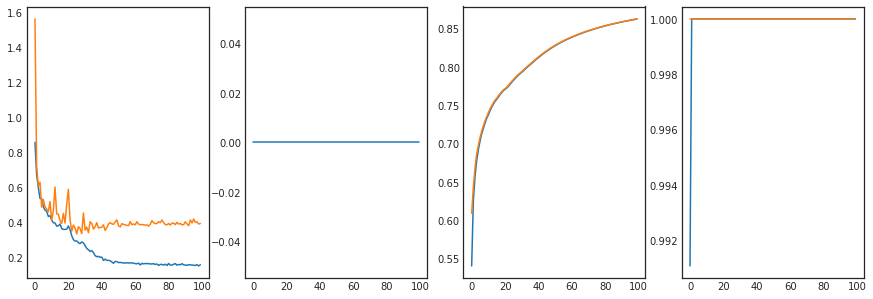

In [15]:
fig, (ax_loss, ax_temp_loss, ax_acc, ax_iou) = plt.subplots(1,4, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_temp_loss.plot(history.epoch, history.history["temperal_mse_loss"], label="Train loss")
# ax_temp_loss.plot(history.epoch, history.history["val_temperal_mse_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mask_mean_iou"], label="Train mask iou")
ax_acc.plot(history.epoch, history.history["val_mask_mean_iou"], label="Validation mask iou")
ax_iou.plot(history.epoch, history.history["temperal_mean_iou"], label="Train temperal iou")
ax_iou.plot(history.epoch, history.history["val_temperal_mean_iou"], label="Validation temperal iou")

# Fine tune threshold

In [16]:
# model = load_model("./model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})

# # used for predict, no dropout
temperal = Temperal_Callback()
model_predict = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.0, training=False)
model_predict.compile(loss=temperal.temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_predict.set_weights(model_train.get_weights())

X_valid = np.expand_dims(np.stack((np.asarray(val_df['img'].values.tolist()))),axis=3)
y_valid = np.expand_dims(np.asarray(val_df['img_mask'].values.tolist()),axis=3)
preds_valid = model_predict.predict(X_valid, batch_size=32, verbose=1)

400/400 [==============================] - 2s 5ms/step


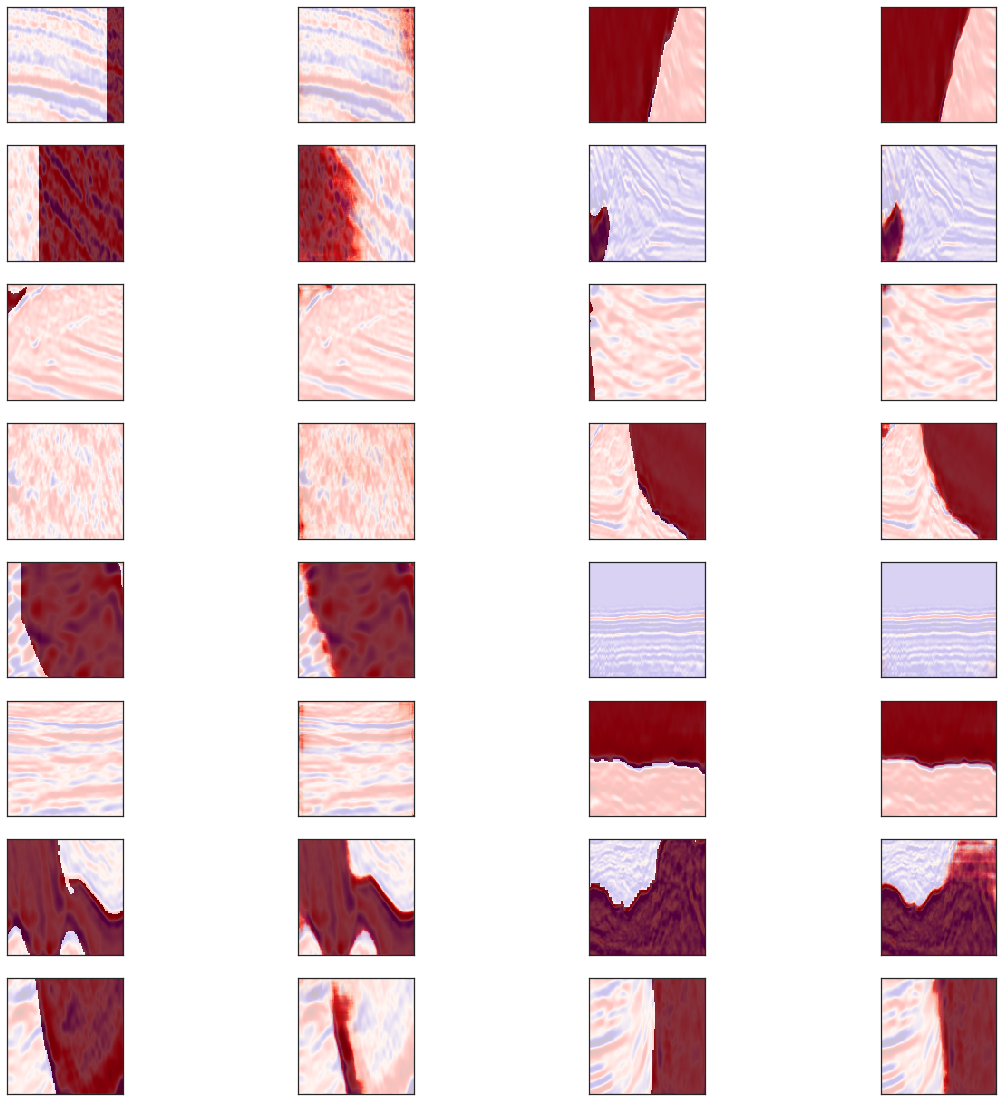

In [17]:
# plot some validate result
base_idx = 10
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(val_df.index[base_idx:base_idx+int(max_images/2)]):
    img = val_df.iloc[i].img
    mask = val_df.iloc[i].img_mask
    pred = preds_valid[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(pred, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]);ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


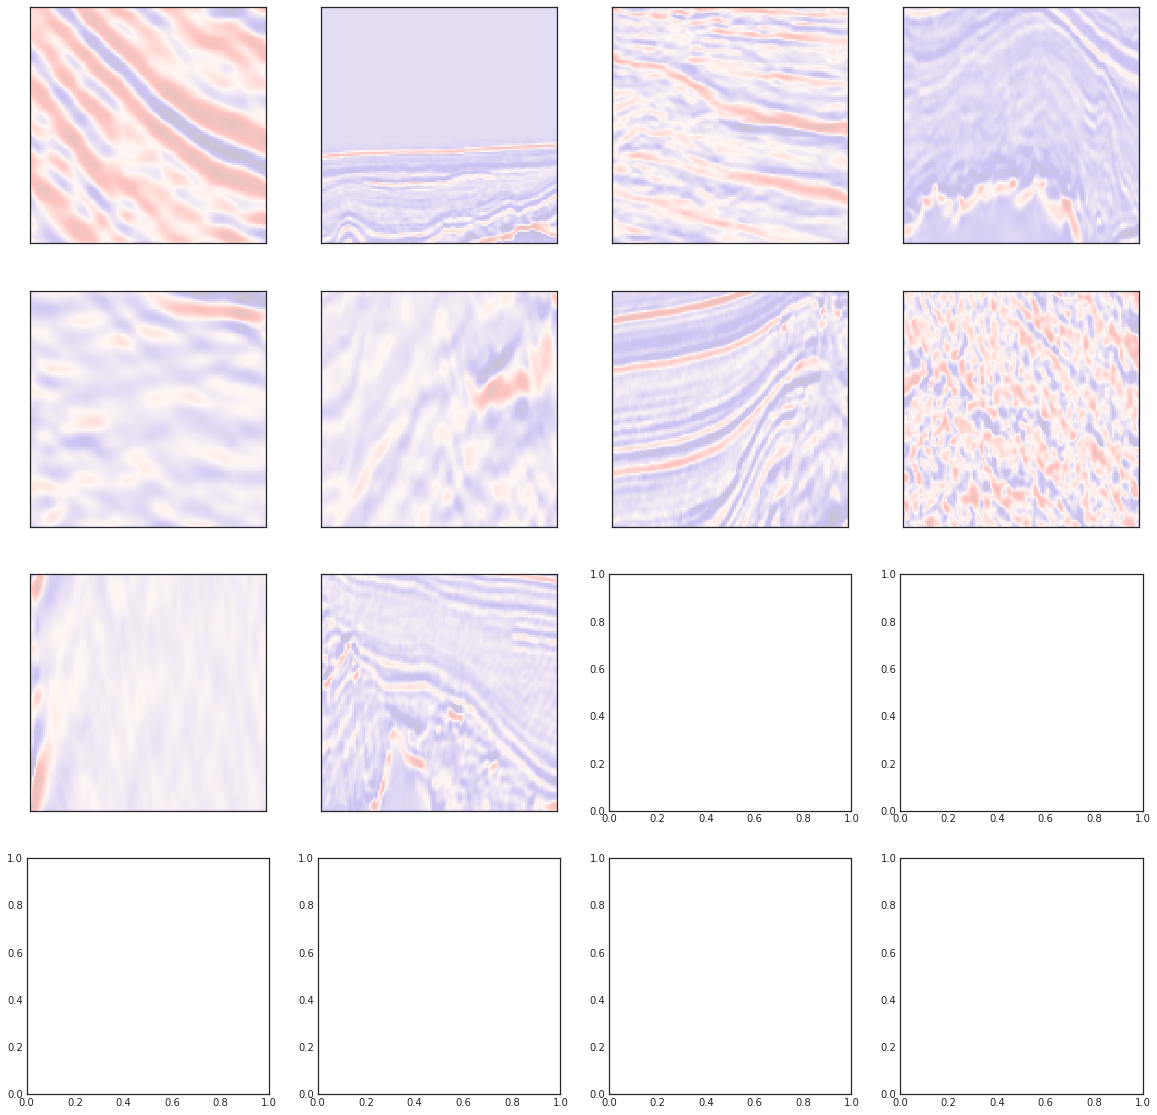

In [18]:
# plot some temperal mask on test results
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(test_df.index[base_idx:base_idx+int(max_images)]):
    img = test_df.loc[idx].img
    mask = test_df.loc[idx].img_temperal_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [19]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch],print_table=False)
        metric.append(value)
    return np.mean(metric)


from math import sqrt
from joblib import Parallel, delayed
import multiprocessing  
from tqdm import tqdm  

thresholds = np.linspace(0, 1, 20)
# result = Parallel(n_jobs=2)(io_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds))
# ious = np.array([iou_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

threshold_best: 0.47368421052631576, iou_best: 0.74575


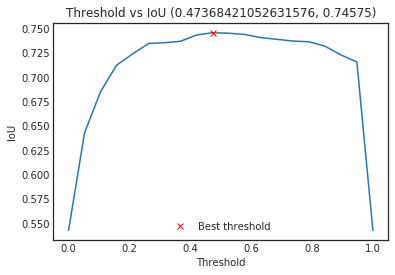

In [20]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'threshold_best: {threshold_best}, iou_best: {iou_best}')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Predict test data

In [21]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [22]:
X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
preds_test = model_predict.predict(X_test, batch_size=32, verbose=1)
final_preds_test = preds_test > threshold_best

10/10 [==============================] - 0s 24ms/step


IndexError: index 160 is out of bounds for axis 0 with size 10

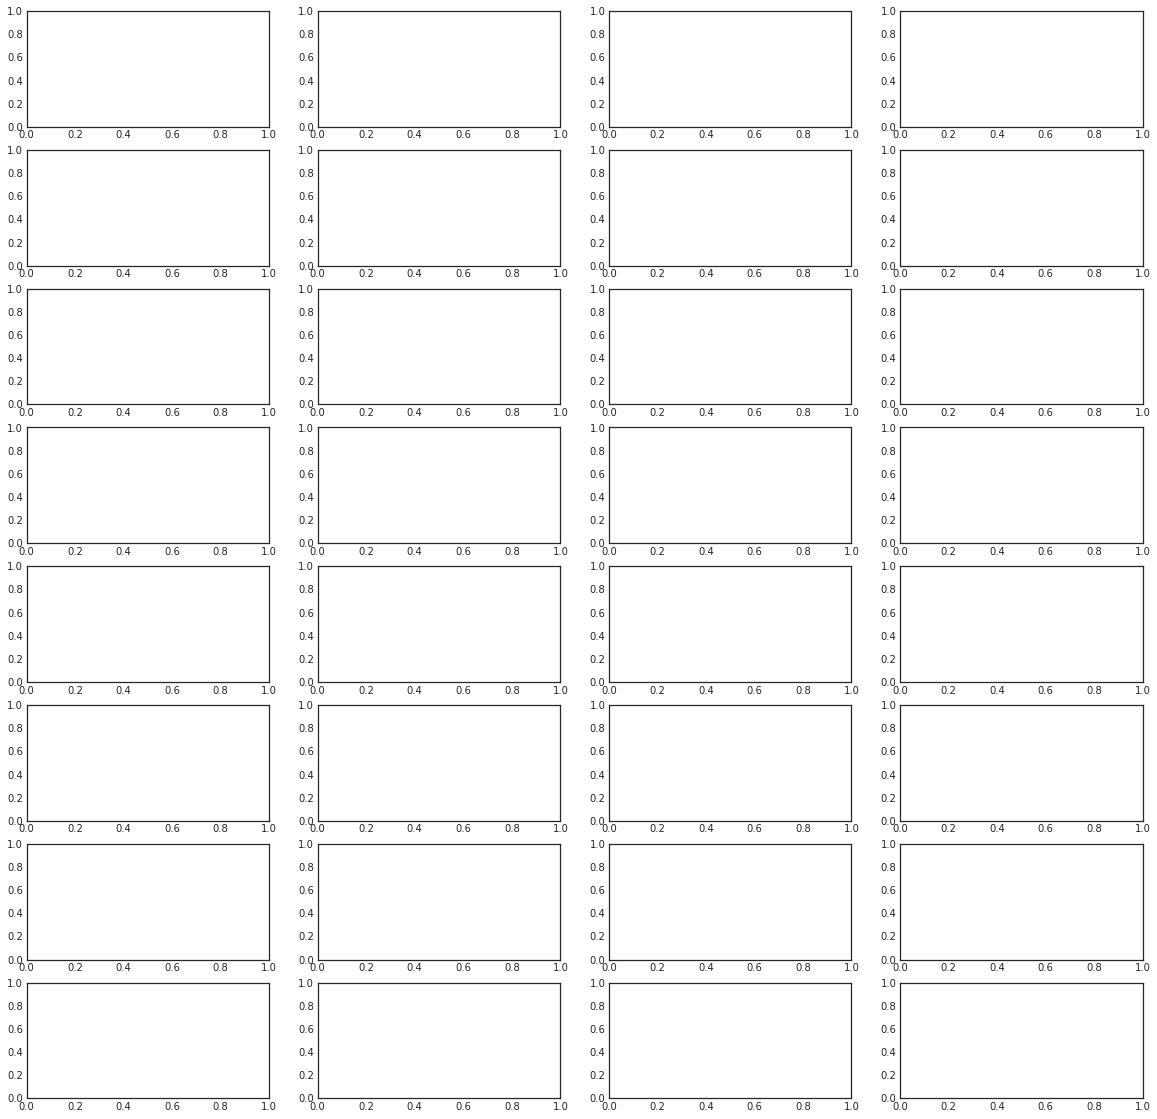

In [23]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

In [ ]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = final_preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

# Apply CRF

In [ ]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [ ]:
"""
Applying CRF on the predicted mask 

"""
crf_output = []
for i in tqdm(range(X_test.shape[0])):
    crf_output.append(crf(np.squeeze(X_test[i]),np.squeeze(final_preds_test[i])))

In [ ]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = crf_output[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

In [ ]:
threshold_best=threshold_best
pred_dict = {idx: RLenc(np.round(downsample(crf_output[i]))) for i, idx in enumerate(tqdm_notebook(test_df.img_id.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_pinet_crf.csv')